**Requirements:**
* Trained models
* GROVER: 
     * fine-tuned:      `'a50dc68191a3776694ce8f34ad55e7e0'` 
     * non-pretrained: `'0807497c5407f4e0c8a52207f36a185f'`


**Outputs:** 
* none 
___
# Imports

In [1]:
import matplotlib
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import scanpy as sc
import seaborn as sns

from utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred

from chemCPA.paths import FIGURE_DIR

[Using backend: pytorch
15:35:52] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/icb/leon.hetzel/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.1.so: cannot open shared object file: No such file or directory


In [2]:
BLACK = True
SAVEFIG = False

In [3]:
if BLACK: 
    plt.style.use('dark_background')
else: 
    matplotlib.style.use("fivethirtyeight")
    matplotlib.style.use("seaborn-talk")
    matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
    sns.set_style("whitegrid")

matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 300
sns.set_context("poster")

In [4]:
%load_ext autoreload
%autoreload 2

## Plotting function

In [5]:
def plot_umap(mapper,
              canon_smiles_unique_sorted, 
              smiles_to_pathway_map, 
              smiles_to_drug_map,
              groups=["Epigenetic regulation", "Tyrosine kinase signaling", "Cell cycle regulation"],
              ood_drugs = [],
              ax=None
             ): 
    # important to use the same ordering of SMILES as was used for getting the embedding!
    if ax == None: 
        fig, ax = plt.subplots(figsize=(12,8))
    
    # groups=["Tyrosine kinase signaling"]
    pathway = []
    drugs = []

    for s in canon_smiles_unique_sorted:
        if s in smiles_to_pathway_map: 
            pathway.append(smiles_to_pathway_map[s])
            drugs.append(smiles_to_drug_map[s])
        else: 
            pathway.append('other')
            drugs.append('unknown')
    
    pathway = np.where(pd.Series(pathway).isin(groups), pathway, "other")
    
#     cmap = [(0.7,0.7,0.7)]
# #     cmap.extend(list(plt.get_cmap('tab20').colors))
# #     cmap = tuple(cmap)

#     sns.scatterplot(x=mapper[:,0], y=mapper[:,1], hue=pathway, palette=cmap, ax=ax)
    cond = pathway != 'other'
    sns.scatterplot(x=mapper[cond,0], y=mapper[cond,1], hue=pathway[cond], ax=ax, palette='tab10' if BLACK else None)
    sns.scatterplot(x=mapper[~cond,0], y=mapper[~cond,1], ax=ax, color='grey', alpha=0.3)
    
    shift = 0.05
    for i, label in enumerate(drugs):
        if drugs[i] in ood_drugs: 
            ax.text(
                x=mapper[i,0]+shift, 
                y=mapper[i,1]+shift,
                s=label,
                fontdict=dict(color='white' if BLACK else 'black', alpha=1, size=12, weight=600),
                bbox=dict(facecolor='black' if BLACK else 'lightgrey', alpha=0.3),
            )
            
            

# Load and analyse model 
* Define `seml_collection` and `model_hash` to load data and model

In [6]:
seml_collection = "finetuning_num_genes"

# GROVER, Setting 1
model_hash_pretrained = "a50dc68191a3776694ce8f34ad55e7e0" # Fine-tuned
model_hash_scratch = "0807497c5407f4e0c8a52207f36a185f" # Non-pretrained


___
## Pretrained model

### Load model

In [7]:
config = load_config(seml_collection, model_hash_pretrained)
dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict, True)
model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
dataset

AnnData object with n_obs × n_vars = 354640 × 977
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'batch', 'n_counts', 'dose_val', 'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'control', 'split_ho_pathway', 'split_tyrosine_ood', 'split_epigenetic_ood', 'split_cellcycle_ood', 'SMILES', 'split_ood_finetuning', 'split_ho_epigenetic', 'split_ho_epigenetic_all', 'split_random'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'gene_id', 'in_lincs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'all_DEGs', 'hvg', 'lincs_DEGs', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#### Define which drugs should be annotaded with list `ood_drugs`

In [9]:
ood_drugs = dataset.obs.condition[dataset.obs.split_ood_finetuning.isin(['ood'])].unique().to_list()

In [10]:
ood_drugs

['Hesperadin',
 'CUDC-101',
 'Raltitrexed',
 'Trametinib',
 'Dacinostat',
 'CUDC-907',
 'Pirarubicin',
 'Tanespimycin',
 'Givinostat']

#### Get pathway level 2 annotation for clustering of drug embeddings

In [11]:
smiles_to_pw_level2_map = {}
pw1_to_pw2 = {}

for (drug, pw1, pw2), df in dataset.obs.groupby(['SMILES', 'pathway_level_1', 'pathway_level_2']): 
    smiles_to_pw_level2_map[drug] = pw2
    if pw1 in pw1_to_pw2:
        pw1_to_pw2[pw1].add(pw2)
    else: 
        pw1_to_pw2[pw1] = {pw2}

In [12]:
groups = [
    "Epigenetic regulation",
    "Tyrosine kinase signaling",
    "Cell cycle regulation",
    "DNA damage & DNA repair"
]

groups_pw2 = [pw2 for pw in groups for pw2 in pw1_to_pw2[pw]]
groups_pw2

['Histone deacetylation',
 'DNA methylation',
 'Histone demethylase',
 'Bromodomain',
 'Histone acetylation',
 'Histone methylation',
 'PI3K-AKT-MTOR activity',
 'MAPK activity',
 'RTK activity',
 'Tyrosine kinase activity',
 'Abl/Src activity',
 'Spindle formation',
 'Aurora kinase activity',
 'Cell cycle regulation',
 'CDK activity',
 'ADP-rybosilation',
 'Toposiomerase activity',
 'Oxidizing agent',
 'Nucleotide analog',
 'Alkylating agent',
 'Crosslinking agent']

### Compute UMAP

In [13]:
transf_embeddings_pretrained_high = compute_drug_embeddings(model_pretrained, embedding_pretrained, dosage=1e4)
mapper_pretrained_high = umap.UMAP(n_neighbors=25, min_dist=0.5).fit_transform(transf_embeddings_pretrained_high)

transf_embeddings_pretrained_low = compute_drug_embeddings(model_pretrained, embedding_pretrained, dosage=10)
mapper_pretrained_low = umap.UMAP(n_neighbors=25, min_dist=0.5).fit_transform(transf_embeddings_pretrained_low)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Plot UMAP

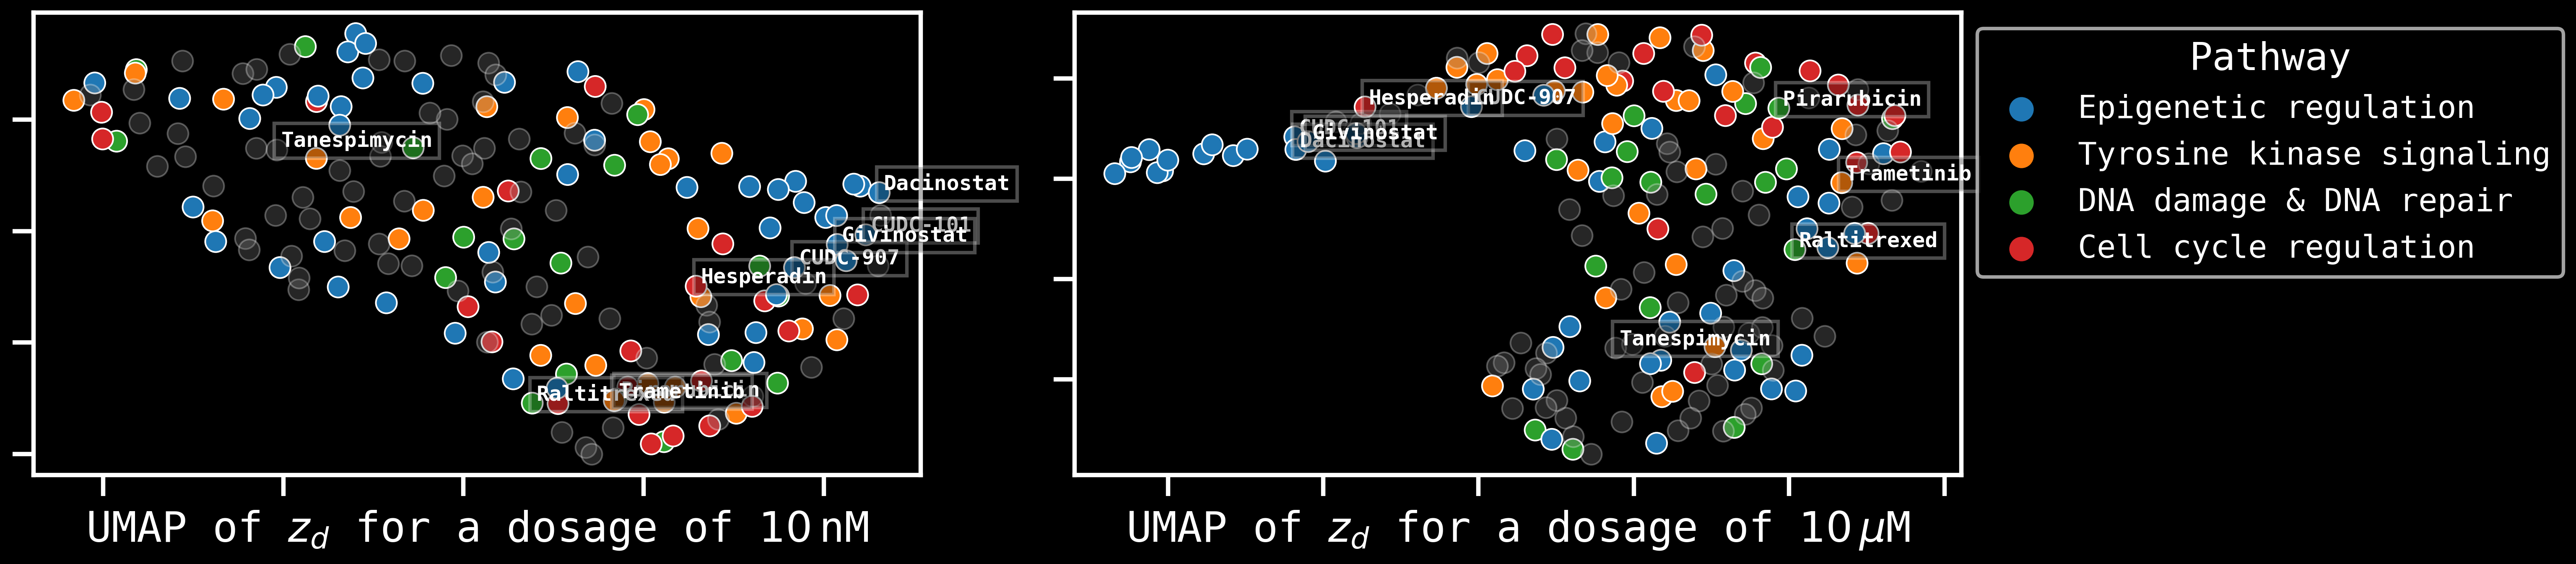

In [14]:
fig, ax = plt.subplots(1,2, figsize=(21,5))

plot_umap(
    mapper_pretrained_high,
    canon_smiles_unique_sorted, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
    groups = groups,
    ood_drugs=ood_drugs,
    ax=ax[1]
)

plot_umap(
    mapper_pretrained_low,
    canon_smiles_unique_sorted, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
    groups = groups,
    ood_drugs=ood_drugs,
    ax=ax[0]
)
ax[0].set(xticklabels=[], yticklabels=[])
ax[0].set_xlabel(f"UMAP of $z_d$ for a dosage of $10\,$nM")

ax[1].set(xticklabels=[], yticklabels=[])
ax[1].set_xlabel(f"UMAP of $z_d$ for a dosage of $10\,\mu$M")

ax[0].grid(False)
ax[1].grid(False)
ax[0].get_legend().remove()
ax[1].legend(title='Pathway', fontsize=18, title_fontsize=22, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

if SAVEFIG: 
    if BLACK:
        plt.savefig(FIGURE_DIR/'umap_drug_embedding_balck.png', format='png')
    else: 
        plt.savefig(FIGURE_DIR/'umap_drug_embedding.png', format='png')

___